# Libraries

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

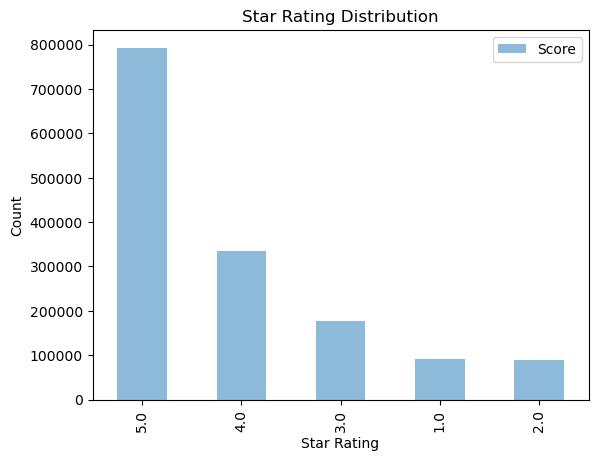


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START
Data has been processed and saved.


/Users/dereklaboy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Vectorizing text data using TF-IDF...
Applying Truncated SVD for dimensionality reduction...
Combining numerical features with reduced text features...
Splitting data into training and validation sets...
Training the Random Forest classifier...
Evaluating the model on validation data...
Validation Accuracy: 0.5831107137471185


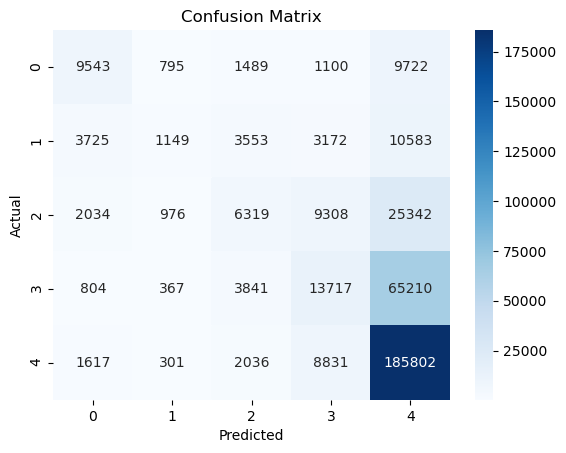

Predicting on test data...
Preparing submission file...
Submission file created at './data/submission.csv'


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title('Star Rating Distribution')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Function to augment the DataFrame with additional features
def augment_data(df):
    # Replace missing 'Text' and 'Summary' with empty strings
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')

    # Compute 'HelpfulnessRatio' as a ratio
    df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['HelpfulnessRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df['HelpfulnessRatio'].fillna(0, inplace=True)

    # Add length features
    df['LengthOfText'] = df['Text'].apply(len)
    df['LengthOfSummary'] = df['Summary'].apply(len)

    # Add word count features
    df['WordCountText'] = df['Text'].str.split().apply(len)
    df['WordCountSummary'] = df['Summary'].str.split().apply(len)

    return df

# Attempt to load preprocessed data; if unavailable, process the data
import os

if os.path.exists('./data/processed_train.csv') and os.path.exists('./data/processed_test.csv'):
    train_data = pd.read_csv("./data/processed_train.csv")
    test_data = pd.read_csv("./data/processed_test.csv")
    print("Loaded processed data from files.")
else:
    # Process training data
    processed_train = augment_data(trainingSet)

    # Merge processed training data with testing set on 'Id'
    test_data = pd.merge(processed_train, testingSet, on='Id', how='right')
    test_data.drop(columns=['Score_x'], inplace=True)
    test_data.rename(columns={'Score_y': 'Score'}, inplace=True)

    # Create train_data by filtering out entries where 'Score' is null
    train_data = processed_train[processed_train['Score'].notnull()]

    # Save processed data
    train_data.to_csv("./data/processed_train.csv", index=False)
    test_data.to_csv("./data/processed_test.csv", index=False)
    print("Data has been processed and saved.")

# Ensure 'Text' and 'Summary' have no missing values
for dataset in [train_data, test_data]:
    dataset['Text'].fillna('', inplace=True)
    dataset['Summary'].fillna('', inplace=True)

# Select features for the model
feature_columns = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'HelpfulnessRatio']
train_features = train_data[feature_columns]
test_features = test_data[feature_columns]

# Vectorize text data using TF-IDF
print("Vectorizing text data using TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_data['Text'])

train_text_tfidf = vectorizer.transform(train_data['Text'])
test_text_tfidf = vectorizer.transform(test_data['Text'])

# Reduce dimensionality using Truncated SVD
print("Applying Truncated SVD for dimensionality reduction...")
svd_model = TruncatedSVD(n_components=50, random_state=42)
svd_model.fit(train_text_tfidf)

train_text_reduced = svd_model.transform(train_text_tfidf)
test_text_reduced = svd_model.transform(test_text_tfidf)

# Combine numerical and text features
print("Combining numerical features with reduced text features...")
train_combined = np.hstack((train_features.values, train_text_reduced))
test_combined = np.hstack((test_features.values, test_text_reduced))

# Define the target variable
target = train_data['Score']

# Split data into training and validation sets
print("Splitting data into training and validation sets...")
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_combined, target, test_size=0.25, random_state=42
)

# Initialize and train the model
print("Training the Random Forest classifier...")
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

# Evaluate the model
print("Evaluating the model on validation data...")
from sklearn.metrics import accuracy_score, confusion_matrix

val_predictions = rf_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")

# Display the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_val, val_predictions)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Make predictions on the test data
print("Predicting on test data...")
test_predictions = rf_classifier.predict(test_combined)

# Prepare the submission file
print("Preparing submission file...")
test_data['Score'] = test_predictions
submission = test_data[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
print("Submission file created at './data/submission.csv'")
